In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Introduction

Purpose: Cleaning of dirty data and scaling of review_score between 0 and 10


```markdown
Data Preprocessing
    >Data Cleaning
      >>Removing Duplicates
      >>Dealing with inconsistent values
          >>>Converting Letter-Based Review Scores
      >>Removing Irrelevant Data
          >>>Anomalous Review Scores
    >Data Scaling
      >>Range 0 to 10
```




# Data Cleaning

Reading csv file and removing rows with empty critic_name

In [2]:
import pandas as pd

path = '/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv'
df = pd.read_csv(path)

df.drop_duplicates(inplace=True)

df = df.dropna(subset=["critic_name"]).reset_index(drop=True)

df['critic_name'] = df['critic_name'].str.strip()
df['review_score'] = df['review_score'].str.strip()


df



,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
3,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
4,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...
...,...,...,...,...,...,...,...,...
994087,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,2/5,2005-11-02,NaN
994088,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme..."
994089,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...
994090,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."


Test to remove rows without critic_name

In [3]:
import unittest
from pandas.testing import assert_frame_equal

class TestDeleteNullValues(unittest.TestCase):

    def setUp(self):
        self.test_data = {
            "critic_name": ["Emanuel Levy", None, "Dennis Schwartz", None , "Brian Orndorf", "Frank Swietek", "Brian Dickerson"]
        }
        self.test_df = pd.DataFrame(self.test_data)

    def delete_null_values(self, df_):
        df_ = df_.dropna(subset=["critic_name"]).reset_index(drop=True)
        return df_

    def test_delete_null_values(self):
        expected_data = {
            "critic_name": ["Emanuel Levy", "Dennis Schwartz", "Brian Orndorf", "Frank Swietek", "Brian Dickerson"]
        }
        expected_df = pd.DataFrame(expected_data)
        current_df = self.delete_null_values(self.test_df)
        assert_frame_equal(expected_df, current_df)

suite = unittest.TestLoader().loadTestsFromTestCase(TestDeleteNullValues)
unittest.TextTestRunner(verbosity=2).run(suite)


test_delete_null_values (__main__.TestDeleteNullValues) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.014s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Assign unique ID to users


In [4]:
unique_names_count_lower = df["critic_name"].str.lower().nunique()

print("Number of unique names (lower):", unique_names_count_lower)


unique_names_count_upper = df["critic_name"].str.upper().nunique()

print("Number of unique names (upper):", unique_names_count_upper)


unique_names_count_case_insensitive = df["critic_name"].nunique()

print("Number of unique names (case-insensitive):", unique_names_count_case_insensitive)


Number of unique names (lower): 11108
Number of unique names (upper): 11108
Number of unique names (case-insensitive): 11108


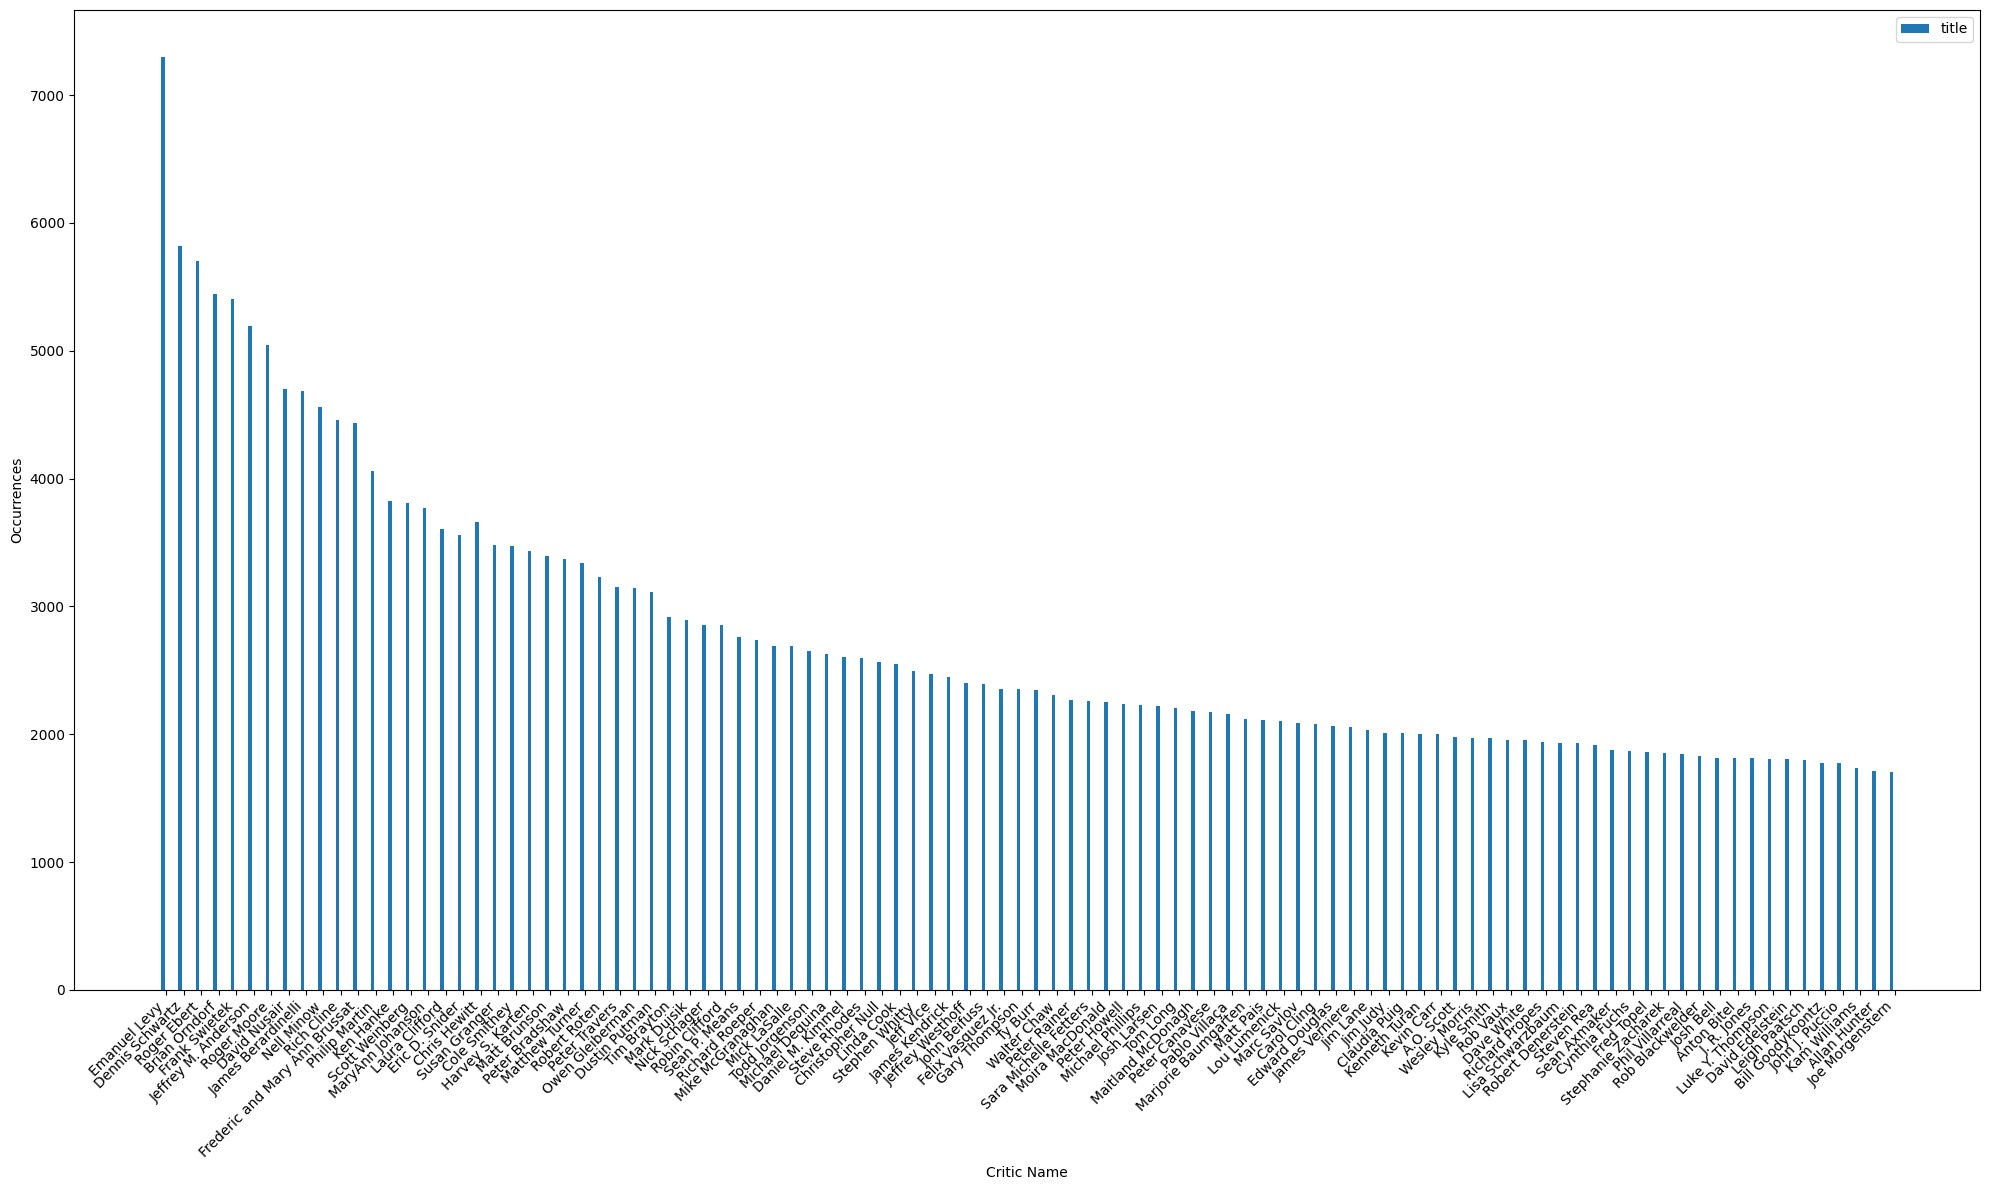

In [5]:
import matplotlib.pyplot as plt

top_critic_names = df["critic_name"].value_counts().head(100)
top_critic_names_dict = top_critic_names.to_dict()

def process_key(key):
    occurrences = {
        'title': df['critic_name'].str.contains(key.title(), case=False).sum(),
        'lower': df['critic_name'].str.contains(key.lower(), case=True).sum(),
        'upper': df['critic_name'].str.contains(key.upper(), case=True).sum()
    }
    return occurrences

keys = list(top_critic_names_dict.keys())

occurrences = {'title': [], 'lower': [], 'upper': []}

for key in keys:
    result = process_key(key)
    for key in occurrences.keys():
        occurrences[key].append(result[key])

bar_width = 0.2
bar_positions = list(range(len(keys)))
bar_positions_dict = {
    'title': [pos + bar_width * 0 for pos in bar_positions],
    'lower': [pos + bar_width * 1 for pos in bar_positions],
    'upper': [pos + bar_width * 2 for pos in bar_positions]
}

plt.figure(figsize=(20, 12))

for key in occurrences.keys():
    if any(occurrences[key]):
        plt.bar(bar_positions_dict[key], occurrences[key], width=bar_width, label=key)

plt.xlabel('Critic Name')
plt.ylabel('Occurrences')
plt.xticks([pos + bar_width for pos in bar_positions], keys, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


Assigning unique IDs to users and movies

In [6]:
user_ids = {}
movie_ids = {}

def assign_unique_id(ids_dict, key_column, key_value):
    if key_value not in ids_dict:
        ids_dict[key_value] = len(ids_dict) + 1
    return ids_dict[key_value]

df['user_id'] = df.apply(lambda row: assign_unique_id(user_ids, 'critic_name', row['critic_name']), axis=1)
df['movie_id'] = df.apply(lambda row: assign_unique_id(movie_ids, 'rotten_tomatoes_link', row['rotten_tomatoes_link']), axis=1)

max_user_id = max(user_ids.values())
max_movie_id = max(movie_ids.values())

print("Total users:", max_user_id)
print("Total movies:", max_movie_id)

df

Total users: 11108
Total movies: 17711


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,user_id,movie_id
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,1,1
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",2,1
2,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3,1
3,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,4,1
4,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...,5,1
...,...,...,...,...,...,...,...,...,...,...
994087,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,2/5,2005-11-02,NaN,301,17711
994088,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",213,17711
994089,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...,223,17711
994090,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th...",307,17711


To test the unique ID assignment function using unittest

In [7]:
user_ids = {}
movie_ids = {}

def assign_unique_id(ids_dict, key_column, key_value):
    if key_value not in ids_dict:
        ids_dict[key_value] = len(ids_dict) + 1
    return ids_dict[key_value]

class TestAssignId(unittest.TestCase):

    def setUp(self):
        self.d = {'critic_name': ["John Smith", "Jane Doe", "John Smith"],
                  'rotten_tomatoes_link': ["m/10", "m/10006270", "m/10006270"]}
        self.expected_user_ids = {"John Smith": 1, "Jane Doe": 2}
        self.expected_movie_ids = {"m/10": 1, "m/10006270": 2}

    def test_assign_unique_id_user(self):
        df = pd.DataFrame(self.d)
        df['user_id'] = df.apply(lambda row: assign_unique_id(user_ids, 'critic_name', row['critic_name']), axis=1)
        self.assertEqual(user_ids, self.expected_user_ids)

    def test_assign_unique_id_movie(self):
        df = pd.DataFrame(self.d)
        df['movie_id'] = df.apply(lambda row: assign_unique_id(movie_ids, 'rotten_tomatoes_link', row['rotten_tomatoes_link']), axis=1)
        self.assertEqual(movie_ids, self.expected_movie_ids)


suite = unittest.TestLoader().loadTestsFromTestCase(TestAssignId)
unittest.TextTestRunner(verbosity=2).run(suite)

test_assign_unique_id_movie (__main__.TestAssignId) ... ok
test_assign_unique_id_user (__main__.TestAssignId) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.028s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [8]:
df_row, df_column = df.shape
df['review_score'] = df['review_score'].astype(str)

anomalous_df = df[df['review_score'].str.match(r'^\d+$')]

anomalous_df_row, anomalous_df_col = anomalous_df.shape
print(anomalous_df_row)
anomalous_df

1420


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,user_id,movie_id
19645,m/1008166-general,Karina Montgomery,False,Cinerina,Fresh,5,2001-06-15,"Sure, it's got that cornball '20's dialogue an...",361,462
24600,m/1016837-promised_land,Kirk Honeycutt,False,honeycuttshollywood.com,Rotten,4,2013-01-07,A dishonest film about duplicity.,148,676
35546,m/1073316-emma,Julia Swift,False,My Champlain Valley,Fresh,7,2020-05-10,If you allow yourself to be transported to thi...,2551,1122
35792,m/1074316-scream,Karina Montgomery,False,Cinerina,Fresh,5,2001-06-14,Kevin Williamson has managed to make a movie t...,361,1128
36580,m/1077077-breakdown,Karina Montgomery,False,Cinerina,Fresh,5,2001-10-24,"It's a cool flick, with a good story, and it's...",361,1148
...,...,...,...,...,...,...,...,...,...,...
992596,m/zombie_for_sale,Kevin Wight,False,The Wee Review,Rotten,2,2020-06-30,Simply not as infectious as its glowing reputa...,4508,17697
992996,m/zombieland_double_tap,Hope Madden,False,Columbus Underground,Fresh,3,2019-10-17,This revival offers just enough fun to not onl...,3536,17700
993518,m/zoolander_2,Kirk Honeycutt,False,honeycuttshollywood.com,Rotten,2,2016-02-11,"A wildly over-plotted, discouragingly unfunny ...",148,17705
993817,m/zootopia,Eric Goldman,False,IGN Movies,Fresh,9,2016-03-02,"Zootopia is a wonderful example of how Disney,...",4969,17708


Ratio of Anomalous Data to Total Data

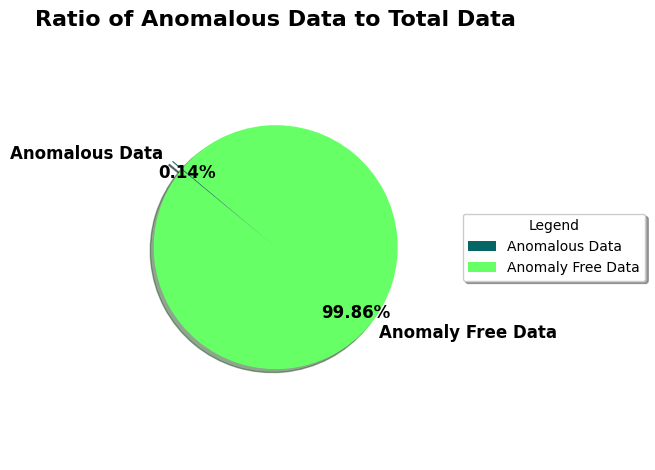

In [9]:
import matplotlib.pyplot as plt

total_rows = df_row
anomalous_rows = anomalous_df_row

anomalous_rows_ratio = (anomalous_rows / total_rows) * 100

labels = ['Anomalous Data', 'Anomaly Free Data']
sizes = [anomalous_rows, total_rows - anomalous_rows]
colors = ['#066666', '#66ff66']
explode = (0.1, 0)

fig, ax = plt.subplots()


wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct='%.2f%%', shadow=True, startangle=140, pctdistance=0.85)

for text in texts + autotexts:
    text.set_fontweight('bold')
    text.set_fontsize(12)

ax.axis('equal')

plt.title('Ratio of Anomalous Data to Total Data', fontsize=16, fontweight='bold')

ax.legend(wedges, labels, title='Legend', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()


The user/movie ratio changes when anomalous data is removed

In [10]:
original_unique_user_count = df["user_id"].nunique()

print("Number of unique user_ids:", original_unique_user_count)


original_unique_movie_count = df["movie_id"].nunique()

print("Number of unique movie_ids:", original_unique_movie_count)

original_df = original_unique_user_count/original_unique_movie_count


Number of unique user_ids: 11108
Number of unique movie_ids: 17711


In [11]:
anomalaus_unique_user_count = anomalous_df["user_id"].nunique()

print("Number of unique user_ids:", anomalaus_unique_user_count)


anomalaus_unique_movie_count = anomalous_df["movie_id"].nunique()

print("Number of unique movie_ids:", anomalaus_unique_movie_count)


Number of unique user_ids: 157
Number of unique movie_ids: 1192


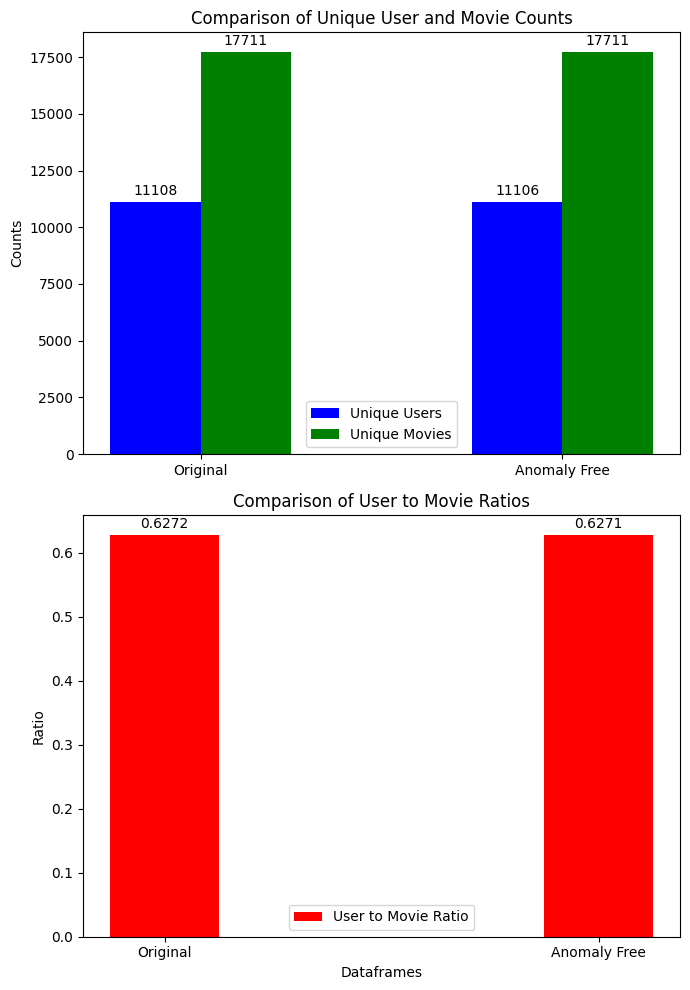

User-to-Movie Ratio Decreased by 0.018%


In [12]:
import matplotlib.pyplot as plt

original_unique_user_count = df["user_id"].nunique()
original_unique_movie_count = df["movie_id"].nunique()
original_ratio = original_unique_user_count / original_unique_movie_count

df.drop(anomalous_df.index, inplace=True)
df.reset_index(drop=True, inplace=True)

new_unique_user_count = df["user_id"].nunique()
new_unique_movie_count = df["movie_id"].nunique()
anomaly_free_ratio = new_unique_user_count / new_unique_movie_count

labels = ["Original", "Anomaly Free"]
user_counts = [original_unique_user_count, new_unique_user_count]
movie_counts = [original_unique_movie_count, new_unique_movie_count]

bar_width = 0.25

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))

r1 = range(len(labels))
r2 = [x + bar_width for x in r1]

bars1 = ax1.bar(r1, user_counts, color='b', width=bar_width, label='Unique Users')
bars2 = ax1.bar(r2, movie_counts, color='g', width=bar_width, label='Unique Movies')

ax1.set_ylabel('Counts')
ax1.set_title('Comparison of Unique User and Movie Counts')
ax1.set_xticks([r + bar_width / 2 for r in r1])
ax1.set_xticklabels(labels)
ax1.legend()

def add_labels(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.annotate(f'{value}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_labels(bars1, user_counts)
add_labels(bars2, movie_counts)

ratios = [original_ratio, anomaly_free_ratio]

bars = ax2.bar(r1, ratios, color='r', width=bar_width, label='User to Movie Ratio')

ax2.set_xlabel('Dataframes')
ax2.set_ylabel('Ratio')
ax2.set_title('Comparison of User to Movie Ratios')
ax2.set_xticks(r1)
ax2.set_xticklabels(labels)
ax2.legend()

def add_ratio_labels(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax2.annotate(f'{value:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_ratio_labels(bars, ratios)

plt.tight_layout()
plt.show()

percentage_decrease = ((original_ratio - anomaly_free_ratio) / original_ratio) * 100

print(f"User-to-Movie Ratio Decreased by {percentage_decrease:.3f}%")


Detecting letter-containing review scores in the dataframe

In [13]:
pattern = r'^[A-Fa-f]\s*[+-]?$'
mask_non_nan = df['review_score'].notna()
review_score_with_letters = df[mask_non_nan].loc[df[mask_non_nan]['review_score'].str.match(pattern, case=False, na=False)]

for index, row in review_score_with_letters.iterrows():
    parts = row['review_score'].split()
    if len(parts) == 2:
        part0, part1 = parts
        letter = (part0 + part1).strip()
        df.loc[index, 'review_score'] = letter
        review_score_with_letters.loc[index, 'review_score']= letter


review_score_with_letters

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,user_id,movie_id
7,m/0814255,Jordan Hoffman,False,UGO,Fresh,B,2010-02-10,"Fun, brisk and imaginative",8,1
13,m/0814255,Peter Paras,False,E! Online,Rotten,C,2010-02-11,This cast is simply too generic. None of the y...,14,1
17,m/0814255,Nell Minow,False,Beliefnet,Fresh,B,2010-02-11,The main thing this movie seems to be missing ...,18,1
31,m/0814255,Tasha Robinson,True,AV Club,Rotten,C-,2010-02-11,"In Columbus' hands, it once again all breaks d...",32,1
36,m/0814255,Cole Smithey,False,ColeSmithey.com,Fresh,B-,2010-02-11,Chris Columbus and his crew take a literal app...,37,1
...,...,...,...,...,...,...,...,...,...,...
992638,m/zorba_the_greek,Emanuel Levy,False,EmanuelLevy.Com,Fresh,B,2007-07-31,"Despite Cacoyannis' plodding helming, and sche...",155,17709
992645,m/zulu,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,A,2000-01-01,"Caine was just splendid, it is still one of hi...",223,17710
992659,m/zulu,Alex von Tunzelmann,True,Guardian,Fresh,B+,2017-07-10,A brilliantly made dramatisation of Rorke's Dr...,1938,17710
992669,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...,223,17711


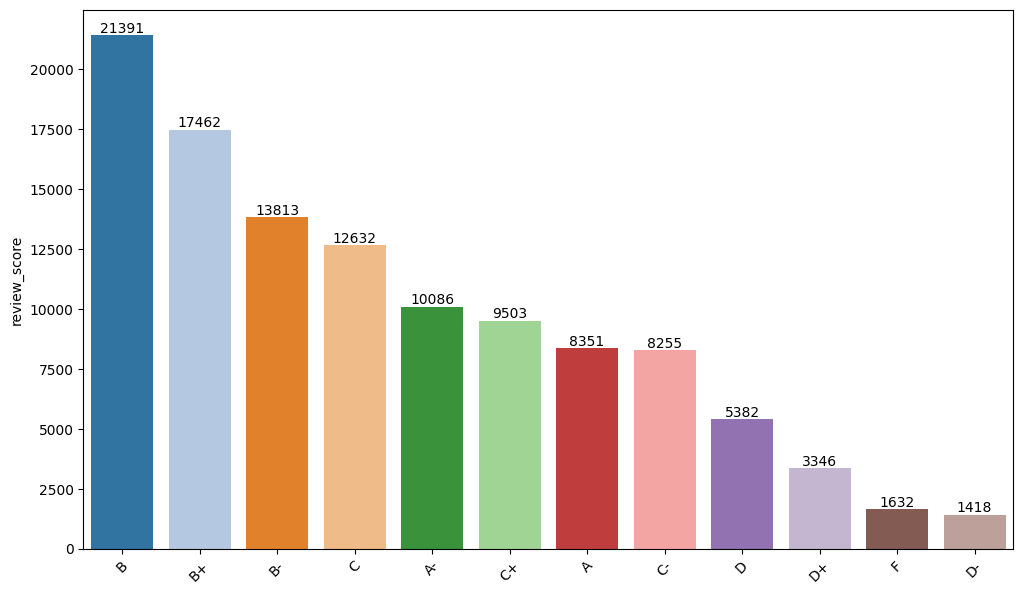

12

In [14]:
import seaborn as sns
data = review_score_with_letters['review_score'].value_counts()
length_of_score_with_rating=len(data)

plt.figure(figsize=(12, 7))
sns.barplot(x=data.index, y=data, palette='tab20')


for index, value in enumerate(data):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.show()

length_of_score_with_rating

Detecting different review score formats

In [15]:
df['review_score'] = df['review_score'].replace({'/00': '/100', '/0': '/10'}, regex=True)

In [16]:
score= df[df['review_score'].notna() & df['review_score'].str.match(r'^\d+(\.\d+)?/\d+$', na=False)]

df[['review_score_num', 'max_score']] = score.review_score.str.split("/", expand = True)

df['max_score'].value_counts()



5       313231
4       226590
10       62018
100       6083
6          891
20         393
8          102
3           25
2           23
11           9
1            8
40           2
70           2
54           2
50           2
13           1
80           1
1000         1
95           1
60           1
9            1
90           1
18           1
45           1
44           1
24           1
Name: max_score, dtype: int64

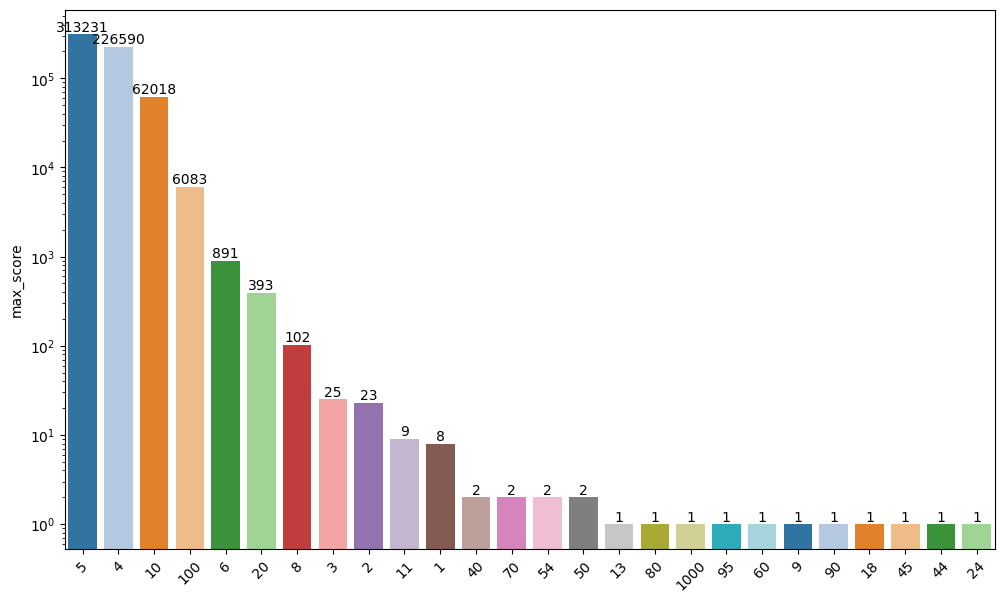

In [17]:
data = df['max_score'].value_counts()

threshold = 1
data[data < threshold] = None

plt.figure(figsize=(12, 7))
sns.barplot(x=data.index, y=data, palette='tab20')


for index, value in enumerate(data.dropna()):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.yscale('log')
plt.show()


# Data Scaling

Converting letter-based review scores to numerical values

In [18]:
interval = 11 / length_of_score_with_rating
i = 10
mapping = {
    'A': 10,
    'A-':0,
    'B+': 0,
    'B': 0,
    'B-': 0,
    'C+': 0,
    'C': 0,
    'C-': 0,
    'D+': 0,
    'D': 0,
    'D-': 0,
    'F': 0
}

for l in mapping:
    if l != 'A':
        mapping[l] = f'{round(interval * i, 3)}/{10}'
        i -= 1

print(mapping)

df['review_score'] = (df['review_score'].apply(lambda x: mapping.get(x,x))).astype(str)

df



{'A': 10, 'A-': '9.167/10', 'B+': '8.25/10', 'B': '7.333/10', 'B-': '6.417/10', 'C+': '5.5/10', 'C': '4.583/10', 'C-': '3.667/10', 'D+': '2.75/10', 'D': '1.833/10', 'D-': '0.917/10', 'F': '0.0/10'}


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,user_id,movie_id,review_score_num,max_score
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,nan,2010-02-06,A fantasy adventure that fuses Greek mythology...,1,1,NaN,NaN
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,nan,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",2,1,NaN,NaN
2,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3,1,3.5,5
3,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,nan,2010-02-10,What's really lacking in The Lightning Thief i...,4,1,NaN,NaN
4,m/0814255,David Germain,True,Associated Press,Rotten,nan,2010-02-10,It's more a list of ingredients than a movie-m...,5,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
992667,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,2/5,2005-11-02,NaN,301,17711,2,5
992668,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",213,17711,3.5,5
992669,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,8.25/10,2010-09-16,A rousing visual spectacle that's a prequel of...,223,17711,NaN,NaN
992670,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th...",307,17711,3.5,5


**Scaling** all review scores between 0 and 10

In [19]:
if not df['review_score'].isnull().all():
    df['review_score'] = df['review_score'].apply(lambda x: float(x.split('/')[0]) / float(x.split('/')[1]) * 10 if isinstance(x, str) and '/' in x else x)
    df['review_score'] = df['review_score'].astype(float).round(3)

df


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,user_id,movie_id,review_score_num,max_score
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,1,1,NaN,NaN
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",2,1,NaN,NaN
2,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,7.000,2010-02-09,Whether audiences will get behind The Lightnin...,3,1,3.5,5
3,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,4,1,NaN,NaN
4,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...,5,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
992667,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,4.000,2005-11-02,NaN,301,17711,2,5
992668,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,7.000,2007-03-07,"Seen today, it's not only a startling indictme...",213,17711,3.5,5
992669,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,8.250,2010-09-16,A rousing visual spectacle that's a prequel of...,223,17711,NaN,NaN
992670,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,7.000,2011-02-28,"A simple two-act story: Prelude to war, and th...",307,17711,3.5,5


Testing the scaling of all review scores to a range of 0 to 10

In [20]:
import numpy as np
def convert(data_frm):
    if not data_frm['review_score'].isnull().all():
        data_frm['review_score'] = data_frm['review_score'].apply(lambda x: float(x.split('/')[0]) / float(x.split('/')[1]) * 10 if isinstance(x, str) and '/' in x else x)
        data_frm['review_score'] = data_frm['review_score'].astype(float).round(3)
    return data_frm

class TestConvert(unittest.TestCase):
    def setUp(self):
        self.sample_data = {'review_score': ['4/4', '3/5', np.nan, '0.13/1', '10/10', '61/100', '2/10', '0.5/5', '2/8', '3/6', '0/4', '76/100', np.nan, np.nan, '7.333/10', '6.417/10', '5.5/10', '4.583/10', '3.667/10']}
        self.expected_data = {'review_score': [10.000, 6.000, np.nan, 1.300, 10.000, 6.100, 2.0, 1.000, 2.500, 5.000, 0.000, 7.600, np.nan, np.nan, 7.333, 6.417, 5.5, 4.583, 3.667]}

    def test_conversion(self):
        data_frm = pd.DataFrame(self.sample_data)
        result = convert(data_frm)
        expected_result = pd.DataFrame(self.expected_data)
        pd.testing.assert_frame_equal(result, expected_result)


suite = unittest.TestLoader().loadTestsFromTestCase(TestConvert)
unittest.TextTestRunner(verbosity=2).run(suite)


test_conversion (__main__.TestConvert) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# Result frame

Detect duplicate user_id and movie_id pairs, and select the one with the most recent review_score

In [21]:
df['review_date'] = pd.to_datetime(df['review_date'])

duplicate_groups = df[df.duplicated(['user_id', 'movie_id'], keep=False)].groupby(['user_id', 'movie_id'])

new_df = []

for _, group in duplicate_groups:
    num_numeric_scores = group['review_score'].notna().sum()

    if group['review_score'].isna().all():
        new_df.append(group.head(1))
    elif num_numeric_scores == 1:
        result = group[group['review_score'].notna()]
        new_df.append(result)
    elif num_numeric_scores > 1:
        max_date_row = group[group['review_score'].notna()].nlargest(1, 'review_date')
        new_df.append(max_date_row)

unique_rows = df[~df.duplicated(['user_id', 'movie_id'], keep=False)]
new_df.append(unique_rows)

new_df = pd.concat(new_df, ignore_index=True)

new_df

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,user_id,movie_id,review_score_num,max_score
0,m/anvil_the_story_of_anvil,Ethan Alter,False,Film Journal International,Fresh,NaN,2009-03-22,An engaging account of the life and times of a...,4,2846,NaN,NaN
1,m/cars,Ethan Alter,False,TV Guide,Fresh,8.750,2006-06-09,It's the one movie so far this summer that dem...,4,4334,3.5,4
2,m/melinda_and_melinda,Ethan Alter,False,NYC Film Critic,Rotten,5.000,2005-03-20,NaN,4,10279,2.5,5
3,m/mr_and_mrs_smith,Ethan Alter,False,NYC Film Critic,Rotten,5.000,2005-06-12,NaN,4,10655,2.5,5
4,m/paycheck,Ethan Alter,False,NYC Film Critic,Fresh,6.000,2005-03-05,NaN,4,11695,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...
987929,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,4.000,2005-11-02,NaN,301,17711,2,5
987930,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,7.000,2007-03-07,"Seen today, it's not only a startling indictme...",213,17711,3.5,5
987931,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,8.250,2010-09-16,A rousing visual spectacle that's a prequel of...,223,17711,NaN,NaN
987932,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,7.000,2011-02-28,"A simple two-act story: Prelude to war, and th...",307,17711,3.5,5


Unit test of the function that detects duplicate user_id and movie_id pairs and selects the one with the most recent review_score

In [22]:
def unique_pair(d_frm):
    d_frm['review_date'] = pd.to_datetime(d_frm['review_date'])

    duplicate_groups = d_frm[d_frm.duplicated(['user_id', 'movie_id'], keep=False)].groupby(['user_id', 'movie_id'])

    col = ['user_id', 'movie_id', 'publisher_name', 'review_score', 'review_date']
    test_new_df = pd.DataFrame(columns=col)

    for _, group in duplicate_groups:
        num_numeric_scores = group['review_score'].notna().sum()

        if group['review_score'].isna().all():
            test_new_df = pd.concat([test_new_df, group.head(1)], ignore_index=True)
        elif num_numeric_scores == 1:
            result = group[group['review_score'].notna()]
            test_new_df = pd.concat([test_new_df, result], ignore_index=True)
        elif num_numeric_scores > 1:
            max_date_row = group[group['review_score'].notna()].nlargest(1, 'review_date')
            test_new_df = pd.concat([test_new_df, max_date_row], ignore_index=True)

    unique_rows = d_frm[~d_frm.duplicated(['user_id', 'movie_id'], keep=False)]
    test_new_df = pd.concat([test_new_df, unique_rows], ignore_index=True)
    return test_new_df

class TestUniquePair(unittest.TestCase):
    def setUp(self):
        self.sample_data = [
            ['1', '2', 'Cinemania', 17, '2014-04-03'],
            ['1', '2', 'indieWire', 10, '2014-06-06'],
            ['1', '2', 'eFilmCritic.com', np.nan, '2016-04-07'],
            ['1', '2', 'Cinema Movil', np.nan, '2016-05-03'],

            ['1', '7', 'Urban Cinefile', np.nan, '2016-05-06'],
            ['1', '7', 'Sarasota Herald-Tribune', np.nan, '2016-05-06'],

            ['6', '7', 'Sarasota Herald-Tribune', np.nan, '2020-02-07'],

            ['8', '2', 'Beliefnet', 1,'2014-07-07']
        ]

        self.expected_data = [
            ['1', '2', 'indieWire', 10, pd.Timestamp('2014-06-06')],
            ['1', '7', 'Urban Cinefile', np.nan, pd.Timestamp('2016-05-06')],
            ['6', '7', 'Sarasota Herald-Tribune', np.nan, pd.Timestamp('2020-02-07')],
            ['8', '2', 'Beliefnet', 1, pd.Timestamp('2014-07-07')]
        ]

    def test_unique_pair(self):
        result = unique_pair(pd.DataFrame(self.sample_data, columns=['user_id', 'movie_id', 'publisher_name', 'review_score', 'review_date']))
        pd.testing.assert_frame_equal(result, pd.DataFrame(self.expected_data, columns=['user_id', 'movie_id', 'publisher_name', 'review_score', 'review_date']))


suite = unittest.TestLoader().loadTestsFromTestCase(TestUniquePair)
unittest.TextTestRunner(verbosity=2).run(suite)

test_unique_pair (__main__.TestUniquePair) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.028s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Test regular expressions to detect anomalous  review scores and normal review scores and review scores containing letters.

In [23]:
import numpy as np

pattern_with_letters = r'^[A-Fa-f]\s*[+-]?$'
pattern_anomalous = r'^\d+$'
ptrn= '^\d+(\.\d+)?/\d+$'

def review_score_with_letters(frame):
    mask = frame['review_score'].notna()
    result_with_letters = frame[mask].loc[frame[mask]['review_score'].str.match(pattern_with_letters, case=False, na=False)]
    result_with_letters = result_with_letters.reset_index(drop=True)

    for index, row in result_with_letters.iterrows():
        parts = row['review_score'].split()
        if len(parts) == 2:
            part0, part1 = parts
            letter = (part0 + part1).strip()
            result_with_letters.loc[index, 'review_score'] = letter
    return result_with_letters

def anomalous_review_score(frame):
    anml_df = frame[frame['review_score'].astype(str).str.match(r'^\d+$')].reset_index(drop=True)
    return anml_df

def review_score(frame):
    score= frame[frame['review_score'].notna() & frame['review_score'].str.match('^\d+(\.\d+)?/\d+$', na=False)].reset_index(drop=True)
    return score

class TestRegex(unittest.TestCase):
    def setUp(self):
        self.sample_data = {'review_score': ['A-', 'B', np.nan, 'C+', '4/4', np.nan, 'F', '3.5/5', '7', '0', '3', 'B            +','B  +', np.nan, '76/100', 'A', 'A  -', 'C', None, None]}
        self.expected_data = {'review_score': ['A-', 'B', 'C+', 'F', 'B+', 'B+', 'A', 'A-', 'C']}
        self.expected_anomalous = {'review_score': ['7', '0', '3']}
        self.expected = {'review_score': ['4/4', '3.5/5', '76/100']}

    def test_review_score_with_letters(self):
        frame = pd.DataFrame(self.sample_data)
        result = review_score_with_letters(frame)
        assert_frame_equal(result, pd.DataFrame(self.expected_data))

    def test_anomalous_review_score(self):
        frame = pd.DataFrame(self.sample_data)
        result_anomalous = anomalous_review_score(frame)
        assert_frame_equal(result_anomalous, pd.DataFrame(self.expected_anomalous))

    def test_review_score(self):
        frame = pd.DataFrame(self.sample_data)
        result_review_score = review_score(frame)
        assert_frame_equal(result_review_score, pd.DataFrame(self.expected))

suite = unittest.TestLoader().loadTestsFromTestCase(TestRegex)
unittest.TextTestRunner(verbosity=2).run(suite)


test_anomalous_review_score (__main__.TestRegex) ... ok
test_review_score (__main__.TestRegex) ... ok
test_review_score_with_letters (__main__.TestRegex) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.069s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

Save output to csv file

In [24]:
new_df["review_score"].fillna('', inplace = True)

pivot_table = new_df.pivot_table(index='user_id', columns='movie_id', values='review_score', aggfunc=lambda x: x)

pivot_table.columns = [f'm_id{col}' for col in pivot_table.columns]

pivot_table.reset_index(inplace=True)

pivot_table.to_csv('/content/drive/MyDrive/file_.csv', index=False)


# Conclusion

Sparsity

In [25]:
import numpy as np

pivot_table.replace('', np.nan, inplace=True)
array = pivot_table.to_numpy()

if array.dtype != np.float64:
    array = array.astype(np.float64)

sparsity =  (np.count_nonzero(np.isnan(array)) / float(array.size))
sparsity_percentage = sparsity * 100
print(f"Percentage: {sparsity_percentage:.2f}%")

Percentage: 99.63%
